# New York City Taxi Fare Prediction

- Mission: 預測紐約市的出租車乘坐的票價（包括通行費）
- Evaluation: mean-squared error or RMSE


In [106]:
# 事前準備
import os
import numpy as np          # 資料處理分析工具
import pandas as pd         # 資料處理分析工具
from scipy import stats     # 統計函式庫
from scipy.stats import norm, skew
import time
notebookstart = time.time()

# 資料視覺化
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color = sns.color_palette() # 生成各種顏色
sns.set_style('darkgrid') # 設置主題：darkgrid、whitegrid、dark、white、ticks

# 忽略警告
import warnings
warnings.filterwarnings("ignore")

## 訓練資料

In [107]:
# 取得訓練資料
dir_data = './data/New York City Taxi Fare Prediction'
train_data = os.path.join(dir_data, 'train.csv')

# 因為資料太多, 因此取前十萬筆; parse_dates可以解析日期
df_train = pd.read_csv(train_data, nrows = 100000, parse_dates=["pickup_datetime"], index_col = 'key')

df_train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
key,,,,,,,
26:21.0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
52:16.0,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
35:00.0,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
30:42.0,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
51:00.0,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


## 測試資料

In [108]:
test_data = os.path.join(dir_data, 'test.csv')
df_test = pd.read_csv(test_data, parse_dates=["pickup_datetime"], index_col = 'key')
df_test.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
key,,,,,,
2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1
2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1
2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.982524,40.751260,-73.979654,40.746139,1
2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981160,40.767807,-73.990448,40.751635,1
2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966046,40.789775,-73.988565,40.744427,1


In [109]:
print("訓練資料 information")
print(df_train.info())
print()
print("測試資料 information")
print(df_test.info())

訓練資料 information
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 26:21.0 to 09:00.0
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   fare_amount        100000 non-null  float64            
 1   pickup_datetime    100000 non-null  datetime64[ns, UTC]
 2   pickup_longitude   100000 non-null  float64            
 3   pickup_latitude    100000 non-null  float64            
 4   dropoff_longitude  100000 non-null  float64            
 5   dropoff_latitude   100000 non-null  float64            
 6   passenger_count    100000 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1)
memory usage: 6.1+ MB
None

測試資料 information
<class 'pandas.core.frame.DataFrame'>
Index: 9914 entries, 2015-01-27 13:08:24.0000002 to 2015-01-18 14:06:23.0000006
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype              
---  ------   

## 確認一下 資料特徵分布
- 發現異常值: 票價有負的
- 發現異常值: 乘客數有 0
- 發現異常值: 票價max竟然到200, 怪怪

In [110]:
df_train.describe()


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,11.354652,-72.494682,39.914481,-72.490967,39.919053,1.673820
std,9.716777,10.693934,6.225686,10.471386,6.213427,1.300171
min,-44.900000,-736.550000,-74.007670,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992041,40.734996,-73.991215,40.734182,1.000000
50%,8.500000,-73.981789,40.752765,-73.980000,40.753243,1.000000
75%,12.500000,-73.966982,40.767258,-73.963433,40.768166,2.000000
max,200.000000,40.787575,401.083332,40.851027,404.616667,6.000000


## 預測的目標: Fare amount
- 票價：乘坐出租車費用的美元金額。
- 票價金額是我們需要預測的變量。所以讓我們先對這個變量進行一些分析。

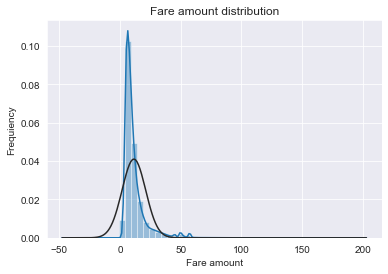

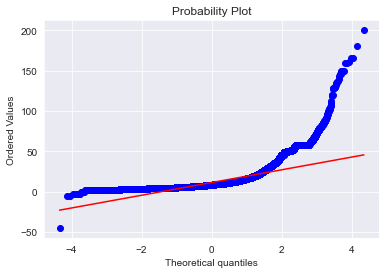

In [111]:
# 繪出分布圖
sns.distplot(df_train['fare_amount'] , fit=norm)    # displot 集合了hist()與核函數估計

plt.ylabel('Frequiency')
plt.xlabel('Fare amount')
plt.title('Fare amount distribution')

# 繪出 QQ-plot 分位圖: 以圖形來檢驗數據是否來自某一分佈的方法
fig = plt.figure() # 方便連續畫幾個圖
res = stats.probplot(df_train['fare_amount'], plot = plt)
plt.show()

## 發現目標變量是歪斜的，因此我們需要轉換此變量並使其更常態分佈。
- 使用 Log-transformation

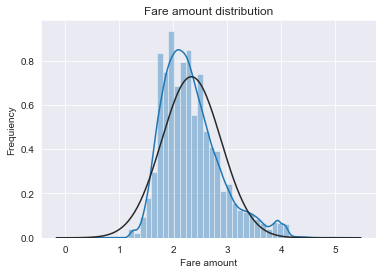

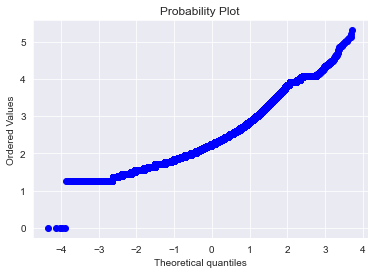

In [112]:
# np.log1p 先將票價做數據平滑處理 使其更加服從高斯分布
df_train['fare_amount'] = np.log1p(df_train['fare_amount'])
# 重新繪製分布圖
sns.distplot(df_train['fare_amount'] , fit=norm) 
plt.ylabel('Frequiency')
plt.xlabel('Fare amount')
plt.title('Fare amount distribution')

fig = plt.figure() # 方便連續畫幾個圖
res = stats.probplot(df_train['fare_amount'], plot = plt)
plt.show()

## 缺失值 Missing value
- 發現存在部分缺失值

In [113]:
# 檢查各個特徵有無缺失值
print(df_train.isnull().sum())

# 直接將缺失值移除
df_train = df_train.dropna()

fare_amount          9
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


## 檢查票價與各特徵的關係
1. passenger count: 出租車乘坐的乘客數量。
- 檢查 outliers
- 發現乘客數為 0, 怪怪的
- 發現票價為 0, 怪怪的 
- 發現乘客數與票價無太大關係

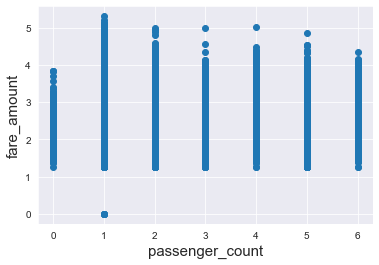


各乘客人數的資料數: 
1    69613
2    14561
5     7033
3     4289
4     2090
6     2039
0      366
Name: passenger_count, dtype: int64


In [114]:
plt.scatter(x = df_train['passenger_count'], y = df_train['fare_amount'])
plt.ylabel('fare_amount', fontsize = 15)
plt.xlabel('passenger_count', fontsize = 15)
plt.show()

print("\r\n各乘客人數的資料數: \r\n" + str(df_train['passenger_count'].value_counts()))

## 檢查票價與各特徵的關係
2. pickup datetime : 當車子start時的時間
- 資料將被分成 年，月，日期，時間和日期
- 發現 2013年後 票價顯著上升
- 發現 5月 & 9-12月票價較高
- 發現一個月中 每天票價差不多
- 發現半夜12點到凌晨5點 票價最高

In [115]:
df_train["year"] = df_train["pickup_datetime"].dt.year
df_train["month"] = df_train["pickup_datetime"].dt.month
df_train["day"] = df_train["pickup_datetime"].dt.day
df_train["hour"] = df_train["pickup_datetime"].dt.hour
df_train["dayofweek"] = df_train["pickup_datetime"].dt.dayofweek

df_train

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,dayofweek
key,,,,,,,,,,,,
26:21.0,1.704748,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,17,0
52:16.0,2.884801,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,16,1
35:00.0,1.902108,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,0,3
30:42.0,2.163323,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,4,5
51:00.0,1.840550,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...
39:00.0,2.302585,2013-09-24 07:39:00+00:00,-73.947977,40.784792,-73.964262,40.792347,5,2013,9,24,7,1
15:45.0,1.945910,2014-05-15 12:15:45+00:00,-73.962918,40.799107,-73.974178,40.786487,1,2014,5,15,12,3
40:43.0,1.791759,2015-02-19 17:40:43+00:00,-73.996773,40.723549,-73.991974,40.724724,1,2015,2,19,17,3


<AxesSubplot:title={'center':'Fare by Day'}, xlabel='dayofweek', ylabel='fare_amount'>

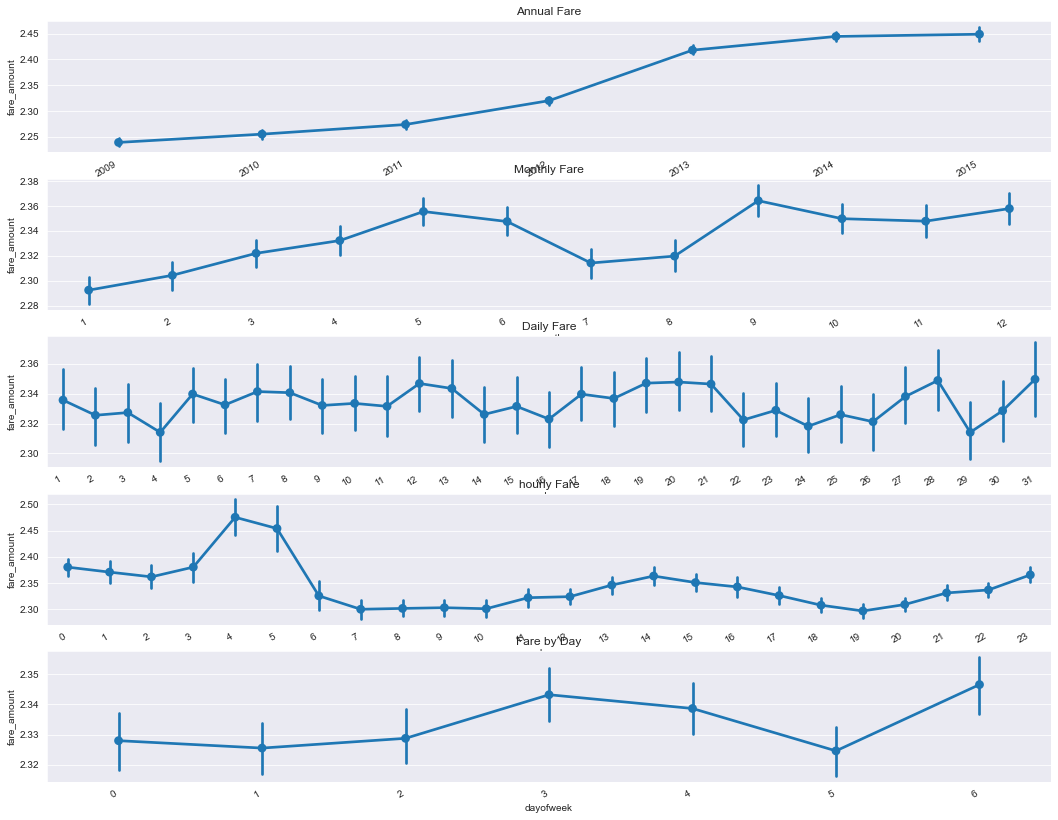

In [116]:
# 建立五個子圖用來顯示年月日小時
fig, axes = plt.subplots(nrows=5)
fig.set_size_inches(18,14)

# 年
plt.sca(axes[0])
plt.xticks(rotation=30, ha='right')
axes[0].set(ylabel='fare_amount',title="Annual Fare")
sns.pointplot(data = df_train, x="year", y="fare_amount", ax=axes[0])

# 月
plt.sca(axes[1])
plt.xticks(rotation=30, ha='right')
axes[1].set(ylabel='fare_amount',title="Monthly Fare")
sns.pointplot(data = df_train, x="month", y="fare_amount", ax=axes[1])

# 日
plt.sca(axes[2])
plt.xticks(rotation=30, ha='right')
axes[2].set(ylabel='fare_amount',title="Daily Fare")
sns.pointplot(data = df_train, x="day", y="fare_amount", ax=axes[2])

# 小時
plt.sca(axes[3])
plt.xticks(rotation=30, ha='right')
axes[3].set(ylabel='fare_amount',title="hourly Fare")
sns.pointplot(data = df_train, x="hour", y="fare_amount", ax=axes[3])

# 週
plt.sca(axes[4])
plt.xticks(rotation=30, ha='right')
axes[4].set(ylabel='fare_amount',title="Fare by Day")
sns.pointplot(data = df_train, x="dayofweek", y="fare_amount", ax=axes[4])

## 檢查票價與各特徵的關係
3. pickup & dropoff coordination: 取放乘客的經緯度座標
- 查看一下 經緯度的資料有無異常值
- 發現有緯度過低 經度過高的資料
- 經度(longitude) 介於 -90 to 90 度之間
- 緯度(latitude) 介於 -180 to 180 度之間
- 由於經緯度不好判斷, 因此可以將它轉成距離

In [117]:
# 檢查 緯度 有無範圍外的資料
print("接到乘客緯度超出範圍的資料數: "+ str(df_train[(df_train['pickup_longitude'] > 180) | (df_train['pickup_longitude'] < -180)]['pickup_longitude'].value_counts()))
print()

print("放下乘客緯度超出範圍的資料數: "+ str(df_train[(df_train['dropoff_longitude'] > 180) | (df_train['dropoff_longitude'] < -180)]['dropoff_longitude'].value_counts()))
print()

# 檢查 經度 有無範圍外的資料
print("接到乘客經度超出範圍的資料數: "+ str(df_train[(df_train['pickup_latitude'] > 90) | (df_train['pickup_latitude'] < -90)]['pickup_latitude'].value_counts()))
print()

print("放下乘客經度超出範圍的資料數: "+ str(df_train[(df_train['dropoff_latitude'] > 90) | (df_train['dropoff_latitude'] < -90)]['dropoff_latitude'].value_counts()))
print()

接到乘客緯度超出範圍的資料數: -736.55    1
Name: pickup_longitude, dtype: int64

放下乘客緯度超出範圍的資料數: Series([], Name: dropoff_longitude, dtype: int64)

接到乘客經度超出範圍的資料數: 401.083332    1
Name: pickup_latitude, dtype: int64

放下乘客經度超出範圍的資料數: 404.616667    1
Name: dropoff_latitude, dtype: int64



## 資料清理 與 特徵工程

In [118]:
# 重新取得資料
train = pd.read_csv('./data/New York City Taxi Fare Prediction/train.csv', nrows = 500000, index_col = "key")
# 直接將缺失值刪掉，因為訓練資料量夠多
train = train.dropna()
test_df = pd.read_csv('./data/New York City Taxi Fare Prediction/test.csv', index_col = "key")
# testdex = test_df.index
# test_df.shape

- ### 準備距離特徵

In [119]:
# 計算經緯度的距離公式
def prepare_distance_features(df):
    
    # Step 1. 先取得經度跟緯度的距離
    df['longitude_distance'] = abs(df['pickup_longitude'] - df['dropoff_longitude'])
    df['latitude_distance'] = abs(df['pickup_latitude'] - df['dropoff_latitude'])

    # Step 2. 再取得直線距離
    df['distance_travelled'] = (df['longitude_distance'] ** 2 + df['latitude_distance'] ** 2) ** 0.5
    df['distance_travelled_sin'] = np.sin((df['longitude_distance'] ** 2 * df['latitude_distance'] ** 2) ** 0.5)
    df['distance_travelled_cos'] = np.cos((df['longitude_distance'] ** 2 * df['latitude_distance'] ** 2) ** 0.5)
    df['distance_travelled_sin_sqrd'] = np.sin((df['longitude_distance'] ** 2 * df['latitude_distance'] ** 2) ** 0.5) ** 2
    df['distance_travelled_cos_sqrd'] = np.cos((df['longitude_distance'] ** 2 * df['latitude_distance'] ** 2) ** 0.5) ** 2
    
    # Haversine formula for distance
    # Haversine formula:	a = sin²(Δφ/2) + cos φ1 ⋅ cos φ2 ⋅ sin²(Δλ/2)
    R = 6371e3 # Metres
    phi1 = np.radians(df['pickup_latitude'])
    phi2 = np.radians(df['dropoff_latitude'])
    phi_chg = np.radians(df['pickup_latitude'] - df['dropoff_latitude'])
    delta_chg = np.radians(df['pickup_longitude'] - df['dropoff_longitude'])
    a = np.sin(phi_chg / 2) + np.cos(phi1) * np.cos(phi2) * np.sin(delta_chg / 2)
    c = 2 * np.arctan2(a ** .5, (1-a) ** .5)
    d = R * c
    df['haversine'] = d

    return df

- ### 準備時間特徵

In [120]:
def prepare_time_features(df):
    df['pickup_datetime'] = df['pickup_datetime'].str.replace(" UTC", "")
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
    df['hour_of_day'] = df.pickup_datetime.dt.hour
    df['week'] = df.pickup_datetime.dt.week
    df['month'] = df.pickup_datetime.dt.month
    df["year"] = df.pickup_datetime.dt.year
    df['day_of_year'] = df.pickup_datetime.dt.dayofyear
    df['week_of_year'] = df.pickup_datetime.dt.weekofyear
    df["weekday"] = df.pickup_datetime.dt.weekday
    df["quarter"] = df.pickup_datetime.dt.quarter
    df["day_of_month"] = df.pickup_datetime.dt.day
    
    return df

### 資料清理

－fare_amount具有負值。刪除。

－緯度和經度具有近0的值，但是紐缺處於（40，-74）因此刪除那些根本不在美國的座標。

－passenting_count具有0的值，刪除。

In [121]:
def clean_df(df):
    return df[(df.fare_amount > 0) & 
            (df.pickup_longitude > -80) & (df.pickup_longitude < -70) &
            (df.pickup_latitude > 35) & (df.pickup_latitude < 45) &
            (df.dropoff_longitude > -80) & (df.dropoff_longitude < -70) &
            (df.dropoff_latitude > 35) & (df.dropoff_latitude < 45) &
            (df.passenger_count > 0) & (df.passenger_count < 10)]

### 重建 Dataframe

In [122]:
# 資料清理
train = clean_df(train)

# 距離特徵
train = prepare_distance_features(train)
test_df = prepare_distance_features(test_df)

# 時間特徵
train = prepare_time_features(train)
test_df = prepare_time_features(test_df)

# 取得距離金額，建立新特徵
train["fare_to_dist_ratio"] = train["fare_amount"] / ( train["distance_travelled"]+0.0001)

train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,longitude_distance,latitude_distance,distance_travelled,distance_travelled_sin,...,hour_of_day,week,month,year,day_of_year,week_of_year,weekday,quarter,day_of_month,fare_to_dist_ratio
count,487913.000000,487913.000000,487913.000000,487913.000000,487913.000000,487913.000000,487913.000000,487913.000000,487913.000000,487913.000000,...,487913.000000,487913.000000,487913.000000,487913.000000,487913.000000,487913.000000,487913.000000,487913.000000,487913.000000,4.879130e+05
mean,11.352118,-73.975237,40.750909,-73.974238,40.751306,1.689988,0.022980,0.021470,0.034405,0.000994,...,13.512026,25.474175,6.271378,2011.737642,175.336175,25.474175,3.041852,2.424600,15.678230,2.274901e+03
std,9.855127,0.045764,0.034048,0.044251,0.037037,1.306024,0.037775,0.027467,0.044573,0.007402,...,6.508364,14.959117,3.439022,1.866081,104.875729,14.959117,1.948891,1.116719,8.680796,2.870681e+04
min,0.010000,-78.725186,37.419853,-78.725186,37.346533,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,2009.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.422938e-01
25%,6.000000,-73.992266,40.736543,-73.991568,40.735600,1.000000,0.006134,0.006936,0.012826,0.000043,...,9.000000,13.000000,3.000000,2010.000000,85.000000,13.000000,1.000000,1.000000,8.000000,2.955334e+02
50%,8.500000,-73.982077,40.753382,-73.980578,40.753882,1.000000,0.012750,0.014183,0.021822,0.000147,...,14.000000,24.000000,6.000000,2012.000000,167.000000,24.000000,3.000000,2.000000,16.000000,3.766753e+02
75%,12.500000,-73.968330,40.767486,-73.965258,40.768418,2.000000,0.023982,0.027227,0.038843,0.000527,...,19.000000,39.000000,9.000000,2013.000000,267.000000,39.000000,5.000000,3.000000,23.000000,4.966813e+02
max,500.000000,-70.140793,43.213962,-70.050500,44.600000,6.000000,4.078017,3.820613,4.110672,0.999783,...,23.000000,53.000000,12.000000,2015.000000,366.000000,53.000000,6.000000,4.000000,31.000000,5.000000e+06


### 處理 Target Variable

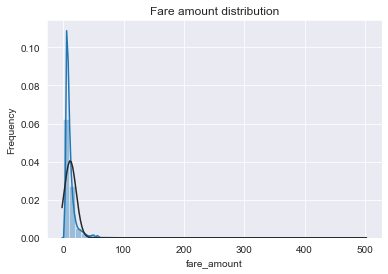

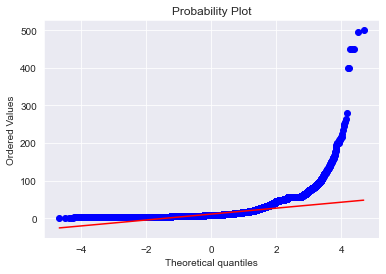

 =============== 數據平滑處理 =============== 


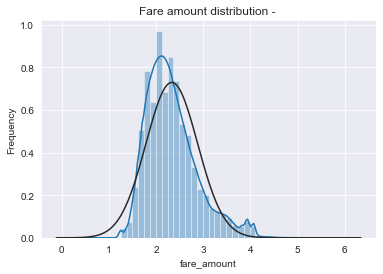

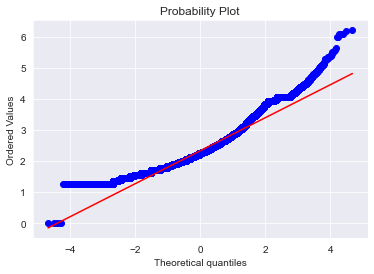

In [123]:
sns.distplot(train['fare_amount'] , fit=norm)
plt.ylabel('Frequency')
plt.title('Fare amount distribution')

fig = plt.figure()
res = stats.probplot(train['fare_amount'], plot=plt)
plt.show()

print(" =============== 數據平滑處理 =============== ")

train["fare_amount"] = np.log1p(train["fare_amount"])

sns.distplot(train['fare_amount'] , fit=norm)
plt.ylabel('Frequency')
plt.title('Fare amount distribution - ')

fig = plt.figure()
res = stats.probplot(train['fare_amount'], plot=plt)
plt.show()

In [124]:
# 保持相關變量
y_train = train['fare_amount']

features_drop = ['pickup_datetime', 'haversine']

test_df.drop(features_drop, axis = 1, inplace=True)

# 讓訓練資料的特徵與測試的相同
train = train[test_df.columns]

In [125]:
train.shape, test_df.shape, len(y_train)

((487913, 21), (9914, 21), 487913)

In [126]:
# 匯入必要的函式庫
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [127]:
# 定義交叉驗證策略
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse = np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    
    return(rmse)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

### 先建立需要用到的模型, 再利用交叉驗證判斷好壞

In [128]:
rf = RandomForestRegressor(n_estimators=300, min_samples_split=9, min_samples_leaf=10, 
                           max_features='sqrt', max_depth=8, bootstrap=False)
# score = rmsle_cv(rf)
# print("\nRandom Forest score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

# XGBoost
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
# score = rmsle_cv(model_xgb)
# print("\nXGBoost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

# LightGBM
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
# score = rmsle_cv(model_lgb)
# print("\nLightGBM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


## Final Training and Prediction
- Blending models
    - Random Forest
    - XGBoost
    - LightGBM

In [129]:
rf.fit(train, y_train)
rf_pred = np.expm1(rf.predict(test_df))

# rmsle(y_train, rf_pred)

In [130]:
model_xgb.fit(train, y_train)
xgb_pred = np.expm1(model_xgb.predict(test_df))

# rmsle(y_train, xgb_pred)

[22:45:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [131]:
model_lgb.fit(train, y_train)
lgb_pred = np.expm1(model_lgb.predict(test_df))

# rmsle(y_train, lgb_pred)

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [132]:
# 混合泛化預測檔 (依 Kaggle 傳回分數調整比重, 越準確者比重越高, 依資料性質有所不同)
blending_pred = rf_pred*0.25 + xgb_pred*0.15 + lgb_pred*0.6

In [133]:
sub = pd.read_csv('./data/New York City Taxi Fare Prediction/sample_submission.csv')
submission = pd.DataFrame()
submission['key'] = sub['key']
submission['fare_amount'] = blending_pred 
submission.to_csv('./data/New York City Taxi Fare Prediction/submission_blending.csv', index = False)